In [1]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer
from transformers import BertConfig, BertForSequenceClassification
import nltk
from nltk.tokenize import sent_tokenize
from keras_preprocessing.sequence import pad_sequences
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from transformers import AdamW, get_linear_schedule_with_warmup
import re
from datetime import datetime

### 데이터 준비

In [78]:
data = pd.read_csv('C:/Users/tlrks/Desktop/workspace/project/SemiProject/SearchScraper/data.csv')

data.dropna(subset=['content', 'title'], inplace=True)

def isLonger(text, length):
    if len(text) > length:
        return True
    else:
        return False

data.drop_duplicates(subset=['title', 'writer'], keep='first', inplace=True)
data.drop_duplicates(subset=['content'], keep='first', inplace=True)
data = data[data.content.apply(isLonger, args=[100])]

data = data[data.title.str.contains('SK') | data.title.str.contains('하이닉스')]

In [3]:
chars_to_remove = [
    '♥', '≪', '”', "'", '(', '🎧', '【', '？', '・', '㎆','℃', '�', '㎸', '㎰', '』', '“',
    '━', '…', '™', '\ufeff', '⋅', '©', '〮', ';', '∙', '↑', '〃', '＜', '］', '®', '》', '×',
    '☎', '＝', '‧', ')', '▷', '〈', '$', '∼', '{', '@', '→', '‥', '】', '－', '-', '″', '—',
    '▶', '`', '!', '"', '㎿', '.', '《', '㎛', '☞', '–', '/', '）', '＆', '=', '|', '?', '≫', 
    '*', '⁺', '~', '▽', '―', '>', '｜', '}', '＞', ':', '㈜', '[', '‘', '㎇', '．', '<', '◈', 
    '･', '↓', '│', '△', '◎', '․', '▼', '◇', '○', '′', '▲', '◀', '㎾', '◆', '’', '『', '↔', '#', 
    '■', '●', '〉', '±', '□', ',', '※', '\u200b', '•']

In [79]:
data['content'] = data['content'].str.replace('↑', '상승', regex=True).replace('↓', '하락', regex=True)
data['content'] = data['content'].str.replace('[^가-힣a-zA-Z0-9 \.\,]', ' ', regex=True).replace(' +', ' ', regex=True)

data['title'] = data['title'].str.replace('↑', '상승', regex=True).replace('↓', '하락', regex=True)
data['title'] = data['title'].str.replace('[^가-힣a-zA-Z0-9 ]', ' ', regex=True).replace(' +', ' ', regex=True)

data['writed_at'] = pd.to_datetime(data['writed_at'], format='%Y-%m-%d %H:%M:%S')

In [10]:
data.head()

,content,keyword,title,url,writed_at,writer
0,"D램, 낸드플래시 매출은 각각 37 , 31 하락 파운드리 공장 2분기 2020년 ...",하이닉스,SK하이닉스 2019년 비메모리 매출 50 상승,https://n.news.naver.com/mnews/article/022/000...,2020-04-01 03:04:05,박세준
2,"이데일리 최정희 기자 삼성전자 005930 , SK하이닉스 000660 주가가 강...",하이닉스,특징주 1분기 실적 호조에 삼성전자 SK하이닉스 강세,https://n.news.naver.com/mnews/article/018/000...,2020-04-07 09:16:04,최정희
3,SK하이닉스 연합뉴스TV 제공 서울 연합뉴스 김기훈 기자 유진투자증권은 14일 신종...,하이닉스,유진투자 하반기 메모리 가격 하락 전망 SK하이닉스 목표가하락,https://n.news.naver.com/mnews/article/001/001...,2020-04-14 08:39:00,김기훈
4,머니투데이 김태현 기자 삼성증권은 SK하이닉스에 대해 환율효과와 낸드마진 등으로 ...,하이닉스,SK하이닉스 낸드마진 개선 1Q 호실적 기대 삼성,https://n.news.naver.com/mnews/article/008/000...,2020-04-20 08:35:37,김태현
5,SK하이닉스가 메모리 반도체 가격 상승에 힘입어 올 1분기 영업이익 8000억원을 ...,하이닉스,SK하이닉스 코로나에도 어닝 서프라이즈 1분기 영업이익 8003억원,https://n.news.naver.com/mnews/article/366/000...,2020-04-23 08:37:21,윤민혁


In [80]:
len(data)

10728

In [81]:
stock_data = pd.read_csv('./stock_data.csv')

stock_data = stock_data.iloc[:760].copy()
stock_data['date'] = pd.to_datetime(stock_data['날짜'])
stock_data['up'] = None

# 전일대비 상승인지 하락인지 1, 0 부여
for i in range(len(stock_data)-1):
    stock_data.loc[i, 'up'] = int(stock_data.loc[i, '종가'] > stock_data.loc[i+1, '종가'])

data['label'] = None
for i in range(len(stock_data)-1):
    end = stock_data.loc[i, 'date'] + pd.Timedelta(hours=15, minutes=30)
    start = stock_data.loc[i+1, 'date'] + pd.Timedelta(hours=15, minutes=30)
    data.loc[(start < data['writed_at'])&(data['writed_at'] < end), 'label'] = stock_data.loc[i, 'up']

labeled_data = data.loc[:, ['content', 'title', 'writed_at', 'label', 'url']]
labeled_data.dropna(inplace=True)
# labeled_data.to_csv('./labeled_data.csv', index=False)

In [19]:
data = pd.read_csv('./labeled_data.csv')

sentences = []
labels = []
for idx, row in data.iterrows():
    article = row['content']
    article_label = row['label']
    sentences.append(re.sub('[\,\.]', ' ', row['title']))
    labels.append(article_label)
    for sentence in sent_tokenize(article):
        sentences.append(re.sub('[\,\.]', ' ', sentence).replace('\ \ ', ' ').strip())
        labels.append(article_label)

df = pd.DataFrame({'sentence': sentences, 'label': labels})
df = df[df.sentence.apply(isLonger, args=[5])]
df.to_csv('./sen_data.csv', index=False)

In [17]:
df.groupby(by='label').count()

,sentence
label,
0,114140
1,101225


In [94]:
data = pd.read_csv('./sen_data.csv')
data

,sentence,label
0,SK하이닉스 2019년 비메모리 매출 50 상승,0
1,D램 낸드플래시 매출은 각각 37 31 하락 파운드리 공장 2분기 2020년 ...,0
2,연합뉴스 SK하이닉스의 지난해 매출액이 전년 대비 33 감소했지만 비메모리 반도체...,0
3,31일 SK하이닉스의 사업보고서에 따르면 2019년 D램 매출은 20조3000억원...,0
4,반면 비메모리 사업을 포함한 기타 항목 매출은 2018년 6500억원에서 지난해 1...,0
...,...,...
215071,그래서 올해 내에 D램이든 낸드 등 고정 가격 반등이 예상되기 때문에 주가의 저점은...,0
215072,앵커 알겠습니다,0
215073,실적보다는 좀 모멘텀에 주목하면서 역발상 투자 전략을 활용하는 게 좋겠다 라는 말...,0
215074,지금까지 ET WHY 노근창 센터장 함께했습니다,0


### 학습

In [31]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
# from transformers import AdamW, get_linear_schedule_with_warmup
import json
import time

In [32]:
class MyDataset(Dataset):
    def __init__(self, data, tokenizer, num_labels=2):
        self.data = data
        self.tokenizer = tokenizer
        self.num_labels = num_labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text = self.data.iloc[idx]['sentence']
        label = self.data.iloc[idx]['label']
        
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=32,
            padding='max_length',
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'# tensor 형식으로 반환
        )
        
        return {
            'input_ids': inputs['input_ids'].squeeze(0),# model에 맞는 모양 갖도록
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'label': torch.tensor(label)
        }
    
def get_dataloader(data, tokenizer, batch_size, num_workers):
    train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)

    train_dataset = MyDataset(train_data, tokenizer)
    test_dataset = MyDataset(test_data, tokenizer)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_dataloader, test_dataloader

def format_time(t):
    h = int(t / 3600)
    m = int((t % 3600) / 60)
    s = int(t % 60)
    return f'{h:02d}:{m:02d}:{s:02d}'

def accuracy(preds, labels):
    """
    preds: 모델의 예측값
    labels: 정답 레이블
    """
    # 예측값의 최대값이 있는 인덱스를 선택
    preds = torch.argmax(preds, dim=1).flatten()
    # 예측값과 실제값이 동일한 경우 1, 그렇지 않은 경우 0을 반환
    correct = torch.eq(preds, labels).sum()
    # 정확도 계산
    acc = correct.float() / float(len(labels))
    return acc

# 모델 출력으로부터 직접 loss 계산 -> 분류 문제에 더 적합
def train_(train_dataloader, test_dataloader, model_name, num_epochs, learning_rate, start_time):
    # epoch별 평균 train accuracy, loss
    train_acc = []
    train_loss = []
    # 하나의 epoch이 끝날 때마다 test_dataloader로 평가한 결과
    epoch_test = []
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print('device :', device)
    # device = torch.device("cpu")

    model = BertForSequenceClassification.from_pretrained(model_name)
    print('pretrained_model :', model_name)
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    print('optimizer : Adam')
    
    for epoch in range(num_epochs):
        total_loss = 0
        total_acc = 0
        model.train()# model을 학습모드 전환
        
        for i, batch in enumerate(train_dataloader):
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, 
                            token_type_ids=None, 
                            attention_mask=attention_mask, 
                            labels=labels)
            
            loss = outputs[0]
            preds = outputs[1]# 원시출력 logits
            acc = accuracy(preds, labels)# 일치 비율을 반환
            if i % 500 == 0 and i != 0:
                print(f'[{format_time(time.time() - start_time)}] {i}번째 batch - - -')
                print(f'loss : {loss.item()}, acc : {acc.item()}')
            total_loss += loss.item()
            total_acc += acc.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            model.zero_grad()

        avg_train_loss = total_loss / len(train_dataloader)
        avg_train_acc = total_acc / len(train_dataloader)
        print(f'[{format_time(time.time() - start_time)}] Epoch {epoch + 1} / {num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}')

        train_acc.append(avg_train_acc)
        train_loss.append(avg_train_loss)
        epoch_test.append(evaluate(test_dataloader, model, device))
    
    print(epoch_test)
    torch.save(model, 'model.pth')
    return train_acc, train_loss, epoch_test

def evaluate(test_dataloader, model, device):
    model.eval()

    total_accuracy = 0
    total_samples = 0

    with torch.no_grad(): # 그래디언트 계산 비활성화
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, 
                            token_type_ids=None, 
                            attention_mask=attention_mask)

            # 모델의 예측 결과 계산
            _, predicted = torch.max(outputs.logits, dim=1)

            # 정확도 계산
            total_accuracy += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = total_accuracy / total_samples
    print(' '*50 + f'test_data accuracy : {accuracy}')

    model.train()
    return accuracy

In [33]:
def main(model_name, num_epochs=10, learning_rate=2e-5, batch_size=64, num_workers=4):
    start_time = time.time()
    tokenizer = BertTokenizer.from_pretrained(model_name)

    tr, te = get_dataloader(data, tokenizer, batch_size, num_workers)

    train_acc, train_loss, epoch_test = train_(tr, te, model_name, num_epochs, learning_rate, start_time)

    result_dict = {'model_name': model_name,
                   'optimizer': 'Adam',
                   'batch': batch_size,
                   'learning_late': learning_rate,
                   'train_accuracy': train_acc,
                   'train_loss': train_loss,
                   'epoch': epoch_test}
    print(result_dict)

    with open('result.json', 'a') as f:
        f.write(json.dumps(result_dict, indent=4) + '\n')
    print(f'[{format_time(time.time() - start_time)}] 실행 완료' + '\n')
    return

In [146]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased')

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [147]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
tokenizer = BertTokenizer.from_pretrained('snunlp/KR-FinBert-SC')

model = BertForSequenceClassification.from_pretrained('snunlp/KR-FinBert-SC')
model.classifier = torch.nn.Linear(in_features=model.classifier.in_features, out_features=2)
model.num_labels = 2

In [ ]:
# 저장된 모델을 불러와서 다시 테스트
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# new_model = BertForSequenceClassification.from_pretrained(model_name)
# new_model.load_state_dict(torch.load('model_weights.pth'))
# new_model.to(device)
# evaluate(te, new_model, device)

---

In [20]:
# x
# from torch_lr_finder import LRFinder

# model = BertForSequenceClassification.from_pretrained("snunlp/KR-FinBert-SC")
# data = pd.read_csv('./sen_data.csv')
# # data = data.loc[:10000, :]
# data.dropna(inplace=True)
# dataset = MyDataset(data)
# dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters())

# lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
# lr_finder.range_test(dataloader, end_lr=1, num_iter=100)
# lr_finder.plot()

In [106]:
tokenizer = BertTokenizer.from_pretrained('snunlp/KR-FinBert-SC')
text = '간밤 뉴욕증시가 7 대 상승하는 등 투자심리도 개선된 모습이다'
print(tokenizer.tokenize(text))

['간', '##밤', '뉴욕', '##증', '##시가', '7', '대', '상승', '##하는', '등', '투자', '##심', '##리도', '개선', '##된', '모습이', '##다']


In [ ]:
tokenizer.decode(tensor([[    2,  1923,  6280, 13679,  5233, 11495,    27,  2418, 10695,  8453,
          2538,  9389,  5452, 14347, 11493,  5041, 11771,  5042,     3,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]]), )

In [55]:
inputs = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=32,
            padding='max_length',
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'# tensor 형식으로 반환
        )

In [56]:
print(inputs['input_ids'])
print(inputs['attention_mask'])

tensor([[    2,  1923,  6280, 13679,  5233, 11495,    27,  2418, 10695,  8453,
          2538,  9389,  5452, 14347, 11493,  5041, 11771,  5042,     3,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])


---

In [106]:
result = {
    "model_name": "snunlp/KR-FinBert-SC",
    "optimizer": "Adam",
    "batch": 64,
    "learning_late": 2e-05,
    "train_accuracy": [
        0.5532747933884298,
        0.630650826446281,
        0.7028254132231405,
        0.7628770661157025,
        0.8120919421487603,
        0.8478357438016529,
        0.8746642561983471,
        0.8952995867768595,
        0.9092148760330578,
        0.9206146694214876
    ],
    "train_loss": [
        0.6827049887278849,
        0.6334574777626795,
        0.558571440621841,
        0.4757402021628766,
        0.39651564396117345,
        0.3332553222455269,
        0.284082009986905,
        0.2440363066625004,
        0.2154013562670424,
        0.19160451152107932
    ],
    "epoch": [
        0.5913613539148224,
        0.6140505858285289,
        0.6089362097824066,
        0.6232564627115492,
        0.6288357820345918,
        0.6262785940115306,
        0.6309280267807328,
        0.6231169797284731,
        0.6262785940115306,
        0.6276269295145992
    ],
    "time_taken": "05:08:34"
}

In [107]:
import matplotlib.pyplot as plt

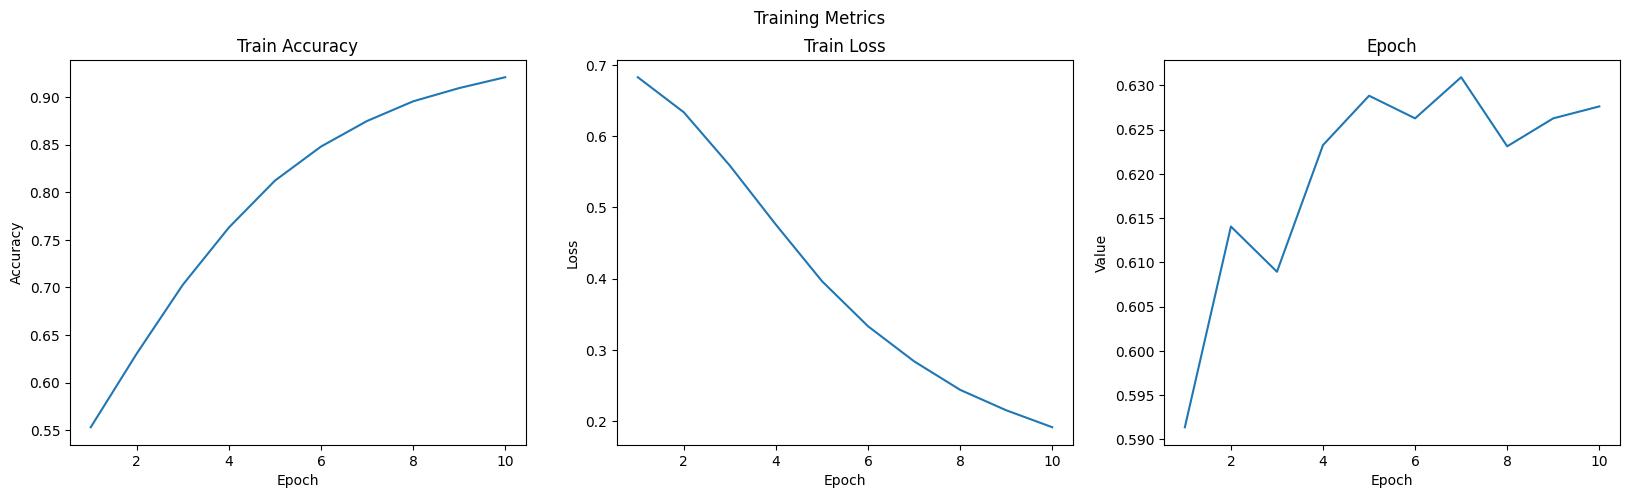

In [111]:
train_accuracy = result['train_accuracy']
train_loss = result['train_loss']
test_accuracy = result['epoch']

x = range(1, 11)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Training Metrics')

ax1.plot(x, train_accuracy)
ax1.set_title('Train Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')

ax2.plot(x, train_loss)
ax2.set_title('Train Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')

ax3.plot(x, test_accuracy)
ax3.set_title('Epoch')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Value')

plt.show()


In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
# with open("./data_in/koreanStopwords.txt", encoding='utf-8') as f:
#     stopwords = f.readlines()
# stopwords = [x.strip() for x in stopwords]

data = pd.read_csv('sen_data.csv')

In [ ]:
text_0 = data[data['label'] == 0]['sentence'].tolist() 
text_1 = data[data['label'] == 1]['sentence'].tolist()

In [ ]:
from konlpy.tag import Komoran

komoran = Komoran()

# text_0에서 명사만 추출
nouns_0 = []
for sentence in text_0:
    for noun in komoran.nouns(sentence):
        if noun not in stopwords:
            nouns_0.append(noun)

# text_1에서 명사만 추출
nouns_1 = []
for sentence in text_1:
    for noun in komoran.nouns(sentence):
        if noun not in stopwords:
            nouns_1.append(noun)

In [127]:
from datetime import datetime, timedelta, time
today = datetime.now().date()
yesterday = today - timedelta(days=1)
today, yesterday

(datetime.date(2023, 5, 3), datetime.date(2023, 5, 2))